## STL-10 Demo
This is the first part of demo on the reduced STL-10 dataset taken from Stanford's [UFLDL tutorial](http://deeplearning.stanford.edu/wiki/index.php/UFLDL_Tutorial). The original [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/) has 10 classes (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck). This reduced dataset contains the images from 4 of the classes (airplane, car, cat, dog).

In this first part of the demo we are going to train a sparse autoencoder on randomly selected small patches of the original images. There are `2 000` training images of size `64x64x3` (width `x` height `x` 3 RGB channels) and from that set `100 000` "patches" of size `8x8x3` have been randomly selected. The aim is to use the learned weights as pre-trained weights for a convolution layer. See the Stanford tutorial for a thorough description of a sparse autoencoder.

In the [second part of the demo]() these weights will be used to initialise a convolutional neural network

### Load Alice
And best to start Julia with multiple threads for processing speed.

In [1]:
using Alice

In [2]:
Base.Threads.nthreads()

4

### Load and display the image patches
Load the "patches" using the **`load_patches`** function.

In [3]:
patches = load_patches()
num_feats, num_patches = size(patches)

(192,100000)

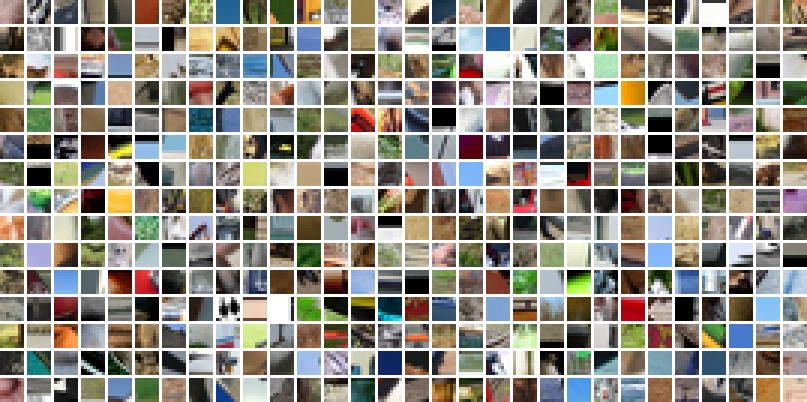

In [4]:
display_rgb_cols(patches[:, 1:450], scale = 3)

### Pre-process the images with ZCA Whitening
Whitening is a pre-processing step with similar steps to PCA (Principle Components Analysis). But instead of using it do reduce the number of dimensions it is used to make the inputs less redundant and more suitable for learning. From the Stanford tutorial:
>If we are training on images, the raw input is redundant, since adjacent pixel values are highly correlated. The goal of whitening is to make the input less redundant; more formally, our desiderata are that our learning algorithms sees a training input where (i) the features are less correlated with each other, and (ii) the features all have the same variance.

See [this page](http://deeplearning.stanford.edu/wiki/index.php/Whitening) for a thorough description which explains the steps below.

In [5]:
# Subtract mean patch
mean_patch = mean(patches, 2)
patches .-= mean_patch

# Apply ZCA whitening
ϵ = 0.1
sigma = patches * patches' ./ num_patches
U, S, V = svd(sigma)
ZCAWhite = U * diagm(1 ./ sqrt(S .+ ϵ)) * U'
patches = ZCAWhite * patches;

### Build and train sparse autoencoder

In [6]:
# Set seed to be able to replicate
srand(123)

# Data Box and Input Layer - the patches are both the input and the target
# Note that for a psarse autoencoder we must use full batch training (i.e. batch_size = num_patches)
databox = Data(patches, patches)
batch_size = num_patches
input = InputLayer(databox, batch_size)

# Sparse Encoder
num_hidden = 400    # number of hidden layer neurons
ρ = 0.035           # desired average activation of the hidden units
β = 5.0             # weight of sparsity penalty term
encoder = SparseEncoderLayer(size(input), num_hidden, ρ, β, activation = :logistic)

# Linear Output Layer
dim_in = 30
num_classes = 10
output = MultiLinearOutputLayer(databox, size(encoder))

# Model
λ = 3e-3            # weight decay parameter
sparse_auto_encoder = NeuralNet(databox, [input, encoder, output], λ, regularisation = :L2)

Neural Network
Training Data Dimensions - (192,100000)
Layers:
Layer 1 - InputLayer{Float64}, Dimensions - (192,100000)
Layer 2 - SparseEncoderLayer{Float64}, Activation - logistic, Dimensions - (400,100000)
Layer 3 - MultiLinearOutputLayer{Float64}, Dimensions - (192,100000)


#### Good idea to check the gradients

In [7]:
check_gradients(sparse_auto_encoder)

Check gradients of a tiny network with similar architecture:

Layer 1, InputLayer{Float64}, Dimensions - (9,40) :

Layer 2, SparseEncoderLayer{Float64}, Activation - logistic, Dimensions - (9,40) :

  Bias parameters relative difference :
  2.3452069658844116e-11

  Weight parameters relative difference :
  6.710240169789753e-10

Layer 3, MultiLinearOutputLayer{Float64}, Dimensions - (9,40) :

  Bias parameters relative difference :
  1.040198493302405e-10

  Weight parameters relative difference :
  2.6426712204813006e-10



### Train the model
Because we are using full batch training we can use the `train_nlopt` function that calls the [NLopt package](https://github.com/JuliaOpt/NLopt.jl) that is a wrapper to the [NLopt library](http://ab-initio.mit.edu/wiki/index.php/NLopt) of nonlinear optimisation routines. The default algorithm is `:LD_LBFGS` (low storage BFGS) but you can choose any of the supported algorithms via the named `algorithm` keyword into the function. E.g. we could call:
`train_nlopt(sparse_autoencoder, maxiter = 400, algorithm = :LD_TNEWTON)` to run the optimisation using the truncated newton algorithm. 

In [8]:
train_nlopt(sparse_auto_encoder, maxiter=400);

Training Loss:
 -> 1097.976 -> 163.804 -> 44.312 -> 64.574 -> 28.256 -> 15.171 -> 13.191 -> 12.803 -> 12.519 -> 11.899 -> 10.881 -> 9.814 -> 8.290 -> 7.824 -> 6.768 -> 6.356 -> 6.280 -> 6.115 -> 5.923 -> 5.733 -> 5.588 -> 5.394 -> 5.334 -> 5.218 -> 5.088 -> 4.986 -> 4.811 -> 4.880 -> 4.750 -> 4.650 -> 4.610 -> 4.566 -> 4.512 -> 4.450 -> 4.406 -> 4.384 -> 4.371 -> 4.345 -> 4.332 -> 4.316 -> 4.296 -> 4.287 -> 4.280 -> 4.263 -> 4.256 -> 4.250 -> 4.241 -> 4.230 -> 4.222 -> 4.214 -> 4.210 -> 4.206 -> 4.203 -> 4.200 -> 4.195 -> 4.189 -> 4.184 -> 4.180 -> 4.178 -> 4.173 -> 4.164 -> 4.167 -> 4.159 -> 4.150 -> 4.147 -> 4.144 -> 4.139 -> 4.134 -> 4.128 -> 4.121 -> 4.119 -> 4.115 -> 4.113 -> 4.109 -> 4.103 -> 4.103 -> 4.099 -> 4.093 -> 4.090 -> 4.087 -> 4.084 -> 4.081 -> 4.075 -> 4.071 -> 4.068 -> 4.064 -> 4.061 -> 4.058 -> 4.055 -> 4.051 -> 4.049 -> 4.044 -> 4.042 -> 4.039 -> 4.036 -> 4.035 -> 4.030 -> 4.029 -> 4.026 -> 4.022 -> 4.025 -> 4.020 -> 4.015 -> 4.012 -> 4.010 -> 4.007 -> 4.004 -> 4.00

### Display the learned network weights
These are the images that maximally "fire" each neuron - given the learned weights. I.e. these are the images that the weights and neurons are - in a sense - looking for. There are many that look like edge detections.

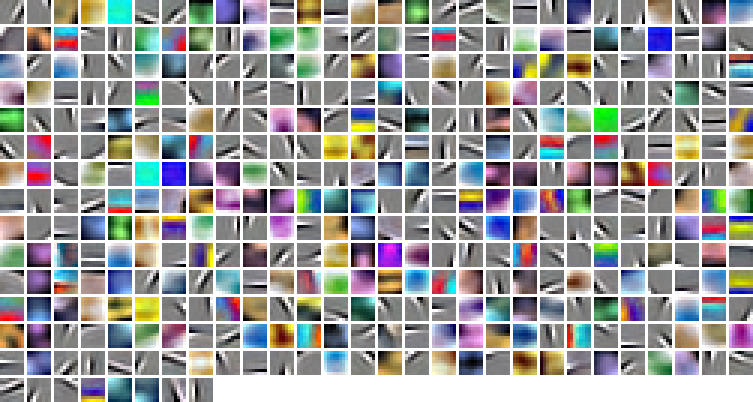

In [9]:
display_rgb_weights(encoder.W', scale=3)

### Modify the learned weights and bias for the whitening pre-processing
We pre-processed the 8x8 image patches by doing the following:
- subtracted the mean of each patch (to zero the mean of each patch)
- whitened by multiplying by the matrix `ZCAWhite`

When we apply these learned weights in our final neural network we will need to pre-process the images in the same way i.e. we need the following for each of the patch inputs into the activation function ($T$ is the whitening matrix and $\bar{x}$ is the mean patch):

$$Z = W(T(x - \bar{x}) + b)$$

But, expanding, we see we can also modify the weights and bias

$$Z = WTx - WT\,\bar{x} + b$$

I.e. we can set
$$\tilde{W} = WT \hspace{0.8cm} \text{and} \hspace{0.8cm} \tilde{b} = b - WT\,\bar{x}$$

and use these adjusted weights and bias on the images without any further pre-processing.

In [ ]:
W = encoder.W * ZCAWhite
b = encoder.b .- squeeze(W * mean_patch, 2);

### Save the learned weights and bias
You can save the weights and bias variables for re-use in your own folders as shown below. For the next part of the tutorial / demo a version of these are already saved in the demo folder.

In [9]:
using JLD
save("C:/...mypath.../stl_features.jld", "W", W, "b", b);